In [1]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 62.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 76.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 106.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 118.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 28.2 MB/s eta 0:00:00


In [8]:
import glob
import os
from multiprocessing import Pool
from pathlib import Path
import pickle

import h5py
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from hdmf_zarr import NWBZarrIO

import utils.new_preprocess as nwp
import utils.nwb_dict_utils as nwb_utils

In [9]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pd.options.mode.copy_on_write = True

In [10]:
def RMSE(x,y):
    return np.sqrt(np.mean((x-y)**2, -1))

def bias(x,y):
    return np.mean(x-y, -1)

def std_of_diff(x,y):
    return np.std(x-y, -1)

In [11]:
parents = sorted(glob.glob("/data/photometry/vary*"))
parents

['/data/photometry/vary_a_max',
 '/data/photometry/vary_a_power',
 '/data/photometry/vary_attenuation',
 '/data/photometry/vary_b_bright',
 '/data/photometry/vary_b_fast',
 '/data/photometry/vary_b_inf',
 '/data/photometry/vary_b_slow',
 '/data/photometry/vary_corr_s',
 '/data/photometry/vary_decay',
 '/data/photometry/vary_motion_power',
 '/data/photometry/vary_noise_std',
 '/data/photometry/vary_t_bright',
 '/data/photometry/vary_t_fast',
 '/data/photometry/vary_t_slow']

In [12]:
def evaluate(parent):
    perf = []
    params = []
    vary = parent.split('/')[-1][5:]
    for nwb_file in sorted(glob.glob(f"{parent}/*/*.nwb")):
        print(f"Processing NWB file: {nwb_file}")
        p = pd.read_csv(Path(nwb_file).parent / "parameters.csv", delimiter=",", index_col=0)
        p = list(p[vary])
        params.append([p[:3], p[3:6]])
        with h5py.File(Path(nwb_file).parent / 'groundtruth.h5') as file:
            dFF_gt = [file[f'fiber{f}']['dff'][:] for f in (0,1)]

        with NWBZarrIO(path=nwb_file, mode="r") as io:
            nwb = io.read()
            # convert nwb to dataframe
            df_from_nwb = nwb_utils.nwb_to_dataframe(nwb)
            # add the session column
            filename = Path(nwb_file).name
            session_name = filename.split(".")[0].split("FIP_")[1]
            df_from_nwb.insert(0, "session", session_name)
            # now pass the dataframe through the preprocessing function:
            df_fip_pp_nwb, df_PP_params = nwp.batch_processing_new(df_fip=df_from_nwb)
            # calculate performance measures
            tmp = []
            for pre in ("poly", "exp", "bright"):
                df = df_fip_pp_nwb[df_fip_pp_nwb["preprocess"]==pre]
                dFF = np.array([[df[(df["channel"] == ch) & (df["fiber_number"] == fiber)]["signal"]
                                 for ch in ['Iso', 'G', 'R']] for fiber in df_fip_pp_nwb["fiber_number"].unique()])
                tmp.append([RMSE(dFF, dFF_gt), bias(dFF, dFF_gt), std_of_diff(dFF, dFF_gt)])
            perf.append(tmp)

    return (np.array(params), # indices: expId, fiber, channel
            np.array(perf))   # indices: expId, method, performance_measure, fiber, channel

In [13]:
nwb_file = "/data/photometry/vary_a_power/FIP_000163_2024-08-06_10-01-24/FIP_000163_2024-08-06_10-01-24.nwb"

In [14]:
perf = []
params = []
vary = "a_power"

In [15]:
import itertools

def batch_processing(df_fip, methods=["poly",]):
    df_fip_pp = pd.DataFrame()
    df_pp_params = pd.DataFrame()

    # df_fip = pd.read_pickle(filename)
    if len(df_fip) == 0:
        return df_fip, df_pp_params

    sessions = pd.unique(df_fip["session"].values)
    sessions = sessions[~pd.isna(sessions)]
    fiber_numbers = np.unique(df_fip["fiber_number"].values)
    channels = pd.unique(df_fip["channel"])  # ['G', 'R', 'Iso']
    channels = channels[~pd.isna(channels)]
    for pp_name in methods:
        if pp_name in ["poly", "exp", "bright"]:
            for i_iter, (channel, fiber_number, session) in enumerate(
                itertools.product(channels, fiber_numbers, sessions)
            ):
                df_fip_iter = df_fip[
                    (df_fip["session"] == session)
                    & (df_fip["fiber_number"] == fiber_number)
                    & (df_fip["channel"] == channel)
                ]
                if len(df_fip_iter) == 0:
                    continue

                NM_values = df_fip_iter["signal"].values
                # try:
                NM_preprocessed, NM_fitting_params = nwp.chunk_processing(NM_values, method=pp_name)
                # except:
                #     print(f"Processing with method {pp_name} failed. Continuing...")
                #     continue
                df_fip_iter.loc[:, "signal"] = NM_preprocessed
                df_fip_iter.loc[:, "preprocess"] = pp_name
                df_fip_pp = pd.concat([df_fip_pp, df_fip_iter], axis=0)

                NM_fitting_params.update(
                    {
                        "preprocess": pp_name,
                        "channel": channel,
                        "fiber_number": fiber_number,
                        "session": session,
                    }
                )
                df_pp_params_ses = pd.DataFrame(NM_fitting_params, index=[0])
                df_pp_params = pd.concat([df_pp_params, df_pp_params_ses], axis=0)

    return df_fip_pp, df_pp_params

In [9]:
qq=[np.array(pd.read_csv(Path(nwb_file).parent / "parameters.csv", delimiter=",", index_col=0)["t_slow"])
  for nwb_file in sorted(glob.glob(f"{parents[-1]}/*/*.nwb"))]
np.nanmedian(qq)

3712.1658291263648

In [31]:
qq=[np.array(pd.read_csv(Path(nwb_file).parent / "parameters.csv", delimiter=",", index_col=0)["t_fast"])
  for nwb_file in sorted(glob.glob(f"{parents[-2]}/*/*.nwb"))]
np.nanmedian(qq)

220.42119205670485

In [32]:
qq=[np.array(pd.read_csv(Path(nwb_file).parent / "parameters.csv", delimiter=",", index_col=0)["t_bright"])
  for nwb_file in sorted(glob.glob(f"{parents[-3]}/*/*.nwb"))]
np.nanmedian(qq)

2073.122248162862

In [16]:
        print(f"Processing NWB file: {nwb_file}")
        p = pd.read_csv(Path(nwb_file).parent / "parameters.csv", delimiter=",", index_col=0)
        p = list(p[vary])
        params.append([p[:3], p[3:6]])
        with h5py.File(Path(nwb_file).parent / 'groundtruth.h5') as file:
            dFF_gt = [file[f'fiber{f}']['dff'][:] for f in (0,1)]

        with NWBZarrIO(path=nwb_file, mode="r") as io:
            nwb = io.read()
            # convert nwb to dataframe
            df_from_nwb = nwb_utils.nwb_to_dataframe(nwb)
            # add the session column
            filename = Path(nwb_file).name
            session_name = filename.split(".")[0].split("FIP_")[1]
            df_from_nwb.insert(0, "session", session_name)
            # now pass the dataframe through the preprocessing function:
            df_fip_pp_nwb, df_PP_params = batch_processing(df_fip=df_from_nwb)
            # calculate performance measures
            tmp = []
            for pre in ("poly", ): #("poly", "exp", "bright"):
                df = df_fip_pp_nwb[df_fip_pp_nwb["preprocess"]==pre]
                dFF = np.array([[df[(df["channel"] == ch) & (df["fiber_number"] == fiber)]["signal"]
                                 for ch in ['Iso', 'G', 'R']] for fiber in df_fip_pp_nwb["fiber_number"].unique()])
                tmp.append([RMSE(dFF, dFF_gt), bias(dFF, dFF_gt), std_of_diff(dFF, dFF_gt)])

Processing NWB file: /data/photometry/vary_a_power/FIP_000163_2024-08-06_10-01-24/FIP_000163_2024-08-06_10-01-24.nwb


In [17]:
df_PP_params

,0,1,2,3,4,QC_metric,preprocess,channel,fiber_number,session
0,3.265138e-12,-2.399607e-08,0.000054,-0.026933,667.585411,NaN,poly,G,1,000163_2024-08-06_10-01-24
0,2.135958e-12,-1.825405e-08,0.000062,-0.132687,1249.656241,NaN,poly,G,2,000163_2024-08-06_10-01-24
0,5.462325e-12,-4.639155e-08,0.000138,-0.176828,508.386383,NaN,poly,Iso,1,000163_2024-08-06_10-01-24
0,6.354249e-12,-4.910404e-08,0.000124,-0.115277,541.385348,NaN,poly,Iso,2,000163_2024-08-06_10-01-24
0,2.194894e-11,-1.818185e-07,0.000457,-0.208369,2917.465424,NaN,poly,R,1,000163_2024-08-06_10-01-24
0,1.224045e-11,-7.545887e-08,0.000100,0.069498,2011.081500,NaN,poly,R,2,000163_2024-08-06_10-01-24


[[array([[0.00957872, 0.01447426, 0.01537848],
         [0.01226334, 0.01011846, 0.01356608]]),
  array([[ 0.00350177, -0.00416861,  0.00239148],
         [ 0.00486335, -0.00649907, -0.0105098 ]]),
  array([[0.00891568, 0.01386098, 0.0151914 ],
         [0.01125776, 0.00775534, 0.00857803]])]]

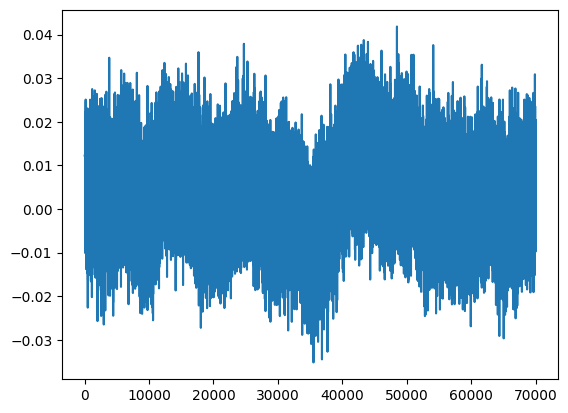

In [11]:
plt.plot(dFF[0][0])
tmp

In [10]:
df_PP_params

,0,1,2,3,QC_metric,preprocess,channel,fiber_number,session
0,663.707073,-0.000014,37.153948,0.022469,NaN,exp,G,1,000163_2024-08-06_10-01-24
0,1149.871856,0.000018,98.564160,0.001068,NaN,exp,G,2,000163_2024-08-06_10-01-24
0,440.930667,0.000025,81.974523,0.004136,NaN,exp,Iso,1,000163_2024-08-06_10-01-24
0,513.946695,0.000006,41.853821,0.009027,NaN,exp,Iso,2,000163_2024-08-06_10-01-24
0,2889.259147,-0.000045,82.501212,0.024626,NaN,exp,R,1,000163_2024-08-06_10-01-24
0,2085.925774,-0.000004,-9.498792,30790.224412,NaN,exp,R,2,000163_2024-08-06_10-01-24


[[array([[0.00957872, 0.01447404, 0.01537842],
         [0.01226336, 0.01011846, 0.01817634]]),
  array([[ 0.00350178, -0.00416791,  0.00239104],
         [ 0.0048634 , -0.00649907, -0.00570408]]),
  array([[0.00891568, 0.01386097, 0.0151914 ],
         [0.01125777, 0.00775534, 0.01725812]])]]

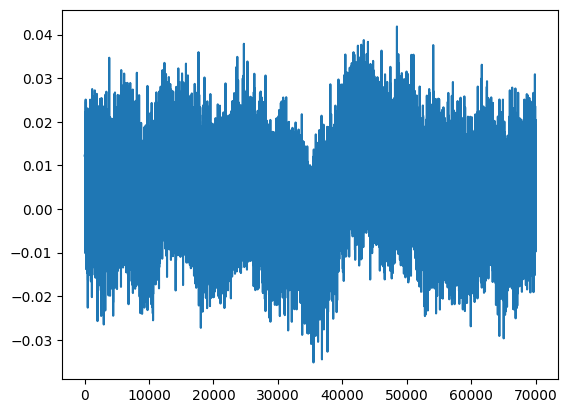

In [11]:
plt.plot(dFF[0][0])
tmp

In [10]:
df_PP_params

,0,1,2,3,QC_metric,preprocess,channel,fiber_number,session
0,625.928009,3600.0,69.547611,146.361359,NaN,exp,G,1,000163_2024-08-06_10-01-24
0,1141.675664,3600.0,126.852862,145.934774,NaN,exp,G,2,000163_2024-08-06_10-01-24
0,471.585192,3600.0,52.398443,146.494515,NaN,exp,Iso,1,000163_2024-08-06_10-01-24
0,493.441960,3600.0,54.826907,155.648981,NaN,exp,Iso,2,000163_2024-08-06_10-01-24
0,2650.395998,3600.0,294.488672,146.151266,NaN,exp,R,1,000163_2024-08-06_10-01-24
0,1853.365333,3600.0,205.929957,145.973621,NaN,exp,R,2,000163_2024-08-06_10-01-24


[[array([[0.04802834, 0.04186753, 0.05618922],
         [0.04039437, 0.04273639, 0.04224653]]),
  array([[ 0.01073101, -0.00846723,  0.00864304],
         [ 0.00561541,  0.0031847 , -0.00824045]]),
  array([[0.04681418, 0.04100239, 0.05552051],
         [0.04000216, 0.04261756, 0.04143506]])]]

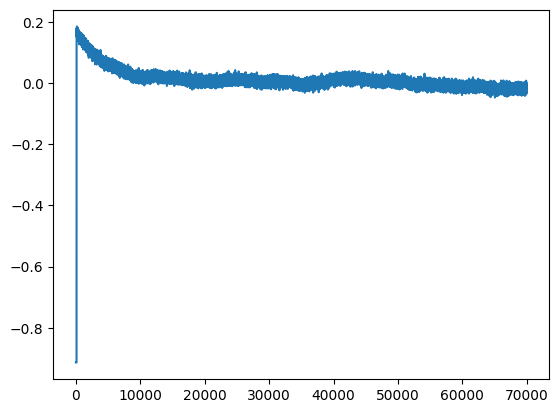

In [11]:
plt.plot(dFF[0][0])
tmp

[[array([[0.04820772, 0.04195866, 0.05625486],
         [0.04046717, 0.04273523, 0.0425291 ]]),
  array([[ 0.0107216 , -0.00847104,  0.0086394 ],
         [ 0.00561238,  0.00318475, -0.00825235]]),
  array([[0.04700034, 0.04109466, 0.05558749],
         [0.04007609, 0.0426164 , 0.04172077]])]]

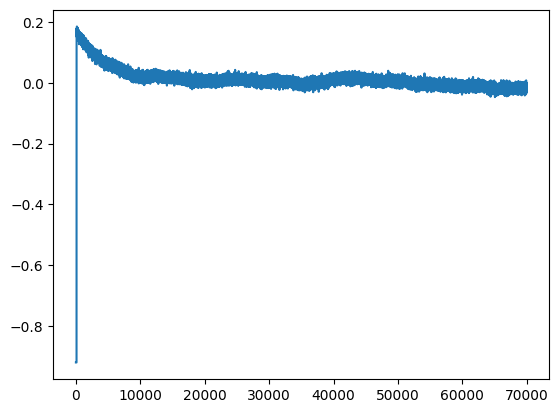

In [19]:
plt.plot(dFF[0][0])
tmp

In [12]:
results = []
for parent in parents:
    print(parent)
    results.append(evaluate(parent))

/data/photometry/vary_a_max
Processing NWB file: /data/photometry/vary_a_max/FIP_000140_2024-08-06_10-01-07/FIP_000140_2024-08-06_10-01-07.nwb
Processing NWB file: /data/photometry/vary_a_max/FIP_000141_2024-08-06_10-01-08/FIP_000141_2024-08-06_10-01-08.nwb
Processing NWB file: /data/photometry/vary_a_max/FIP_000142_2024-08-06_10-01-08/FIP_000142_2024-08-06_10-01-08.nwb
Processing NWB file: /data/photometry/vary_a_max/FIP_000143_2024-08-06_10-01-09/FIP_000143_2024-08-06_10-01-09.nwb
Processing NWB file: /data/photometry/vary_a_max/FIP_000144_2024-08-06_10-01-10/FIP_000144_2024-08-06_10-01-10.nwb
Processing NWB file: /data/photometry/vary_a_max/FIP_000145_2024-08-06_10-01-11/FIP_000145_2024-08-06_10-01-11.nwb
Processing NWB file: /data/photometry/vary_a_max/FIP_000146_2024-08-06_10-01-11/FIP_000146_2024-08-06_10-01-11.nwb
Processing NWB file: /data/photometry/vary_a_max/FIP_000147_2024-08-06_10-01-12/FIP_000147_2024-08-06_10-01-12.nwb


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


/data/photometry/vary_a_power
Processing NWB file: /data/photometry/vary_a_power/FIP_000156_2024-08-06_10-01-19/FIP_000156_2024-08-06_10-01-19.nwb
Processing NWB file: /data/photometry/vary_a_power/FIP_000157_2024-08-06_10-01-20/FIP_000157_2024-08-06_10-01-20.nwb
Processing NWB file: /data/photometry/vary_a_power/FIP_000158_2024-08-06_10-01-21/FIP_000158_2024-08-06_10-01-21.nwb
Processing NWB file: /data/photometry/vary_a_power/FIP_000159_2024-08-06_10-01-21/FIP_000159_2024-08-06_10-01-21.nwb
Processing NWB file: /data/photometry/vary_a_power/FIP_000160_2024-08-06_10-01-22/FIP_000160_2024-08-06_10-01-22.nwb


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Processing NWB file: /data/photometry/vary_a_power/FIP_000161_2024-08-06_10-01-23/FIP_000161_2024-08-06_10-01-23.nwb


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Processing NWB file: /data/photometry/vary_a_power/FIP_000162_2024-08-06_10-01-24/FIP_000162_2024-08-06_10-01-24.nwb


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


Processing NWB file: /data/photometry/vary_a_power/FIP_000163_2024-08-06_10-01-24/FIP_000163_2024-08-06_10-01-24.nwb
Processing with method exp failed. Continuing...


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:503: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:58: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x0
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:591: RuntimeWarning: invalid value encountered in scalar subtract
  dx = x1[i] - x0[i]  # Recompute dx as exactly representable number.


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 3) + inhomogeneous part.

In [10]:
%%time
%%capture
results = Pool(int(os.environ['CO_CPUS'])).map(evaluate, parents)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 3) + inhomogeneous part.

CPU times: user 190 ms, sys: 104 ms, total: 294 ms
Wall time: 50min 13s


In [11]:
# Save to a pickle file
with open('comparison.pkl', 'wb') as f:
    pickle.dump(results, f)

NameError: name 'results' is not defined

In [ ]:
rows = len(results)
fig = plt.figure(layout="constrained", figsize=(12,2.5*rows))
subfigs = fig.subfigures(rows, 3, wspace=0.05)
for row in range(rows):
    params, perf = results[row]
    vary = parents[row].split('/')[-1][5:]
    for col in range(3):
        ax0, ax1 = subfigs[row, col].subplots(1, 2, width_ratios=[4, 1], sharey=True)
        for k in range(len(perf[0])):
            ax0.scatter(params[...,0].ravel(), perf[:,k,col,:,0].ravel(), c=f'C{k}', s=50, marker='+')
            ax0.scatter(params[...,1].ravel(), perf[:,k,col,:,1].ravel(), c=f'C{k}', s=20, marker='o')
            ax0.scatter(params[...,2].ravel(), perf[:,k,col,:,2].ravel(), c=f'C{k}', s=50, marker='x')
            ax1.boxplot(perf[:,k,col].ravel(),
                        positions=[k], widths=.7, showmeans=True, notch=True,
                        boxprops=dict(color=f'C{k}'), flierprops=dict(markeredgecolor=f'C{k}'),
                        meanprops=dict(markerfacecolor=f'C{k}', markeredgecolor=f'C{k}', markersize=3))
            ax1.set_xticks([])
        if col+row==0:
            ax0.legend(handles=[Patch(color='C0', label='poly'),
                                Patch(color='C1', label='exp'),
                                Patch(color='C2', label='bright'),
                                Line2D([], [], color='k', markersize=7, marker='+', linestyle='None', label='Isosbestic'),
                                Line2D([], [], color='k', markersize=4, marker='o', linestyle='None', label='Green'),
                                Line2D([], [], color='k', markersize=7, marker='x', linestyle='None', label='Red')],
                      loc=(-.2,.4))
        ax0.set_xlabel(vary)
        ax0.set_ylabel(['RMSE', 'bias', 'std'][col])
        if row==0:
            ax0.set_title('dF/F')